# Description

This notebook encompasses the **Data generation**, **Model importation**, and **Testing** of 2 newly developed models `mamba` and `mamba2`.

# Dataset

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

input_len = 8 * 6
output_len = 8 * 6


# Generate sine data
def generate_data(num_points):
    x = np.linspace(0, 3 * np.pi, num_points)
    data = np.sin(x)*10 + np.sin(x*20)*3 + np.sin(x*2)*2
    return data


class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len, output_len):
        self.data = data
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.data) - self.input_len - self.output_len

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx + self.input_len]
        target_seq = self.data[idx +
                                    self.input_len:idx + self.input_len + self.output_len]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)


# train set : idx in [0, 800]
# validation set : idx in [801, 1000]
# test set : idx in [1001, 1250]

scaler = StandardScaler()
# Generate 1000 points of sine and cosine data
num_points = 1250 + input_len + output_len
sine_data = generate_data(num_points)
sine_data = scaler.fit_transform(sine_data.reshape(-1, 1)).flatten()

# Create dataset and split into training and testing sets
dataset = TimeSeriesDataset(sine_data, input_len, output_len)

train_size = 800
val_size = 200
test_size = 250
batch_size = 32
train_dataset, val_dataset, test_dataset = Subset(dataset, range(train_size)), Subset(
    dataset, range(train_size, train_size+val_size)), Subset(dataset, range(train_size+val_size, len(dataset)))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Mamba

The `mamba` model tested in this notebook is imported from a simplified version derived from the official `mamba` repository.

In [ ]:
# Redefine patch embedding
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, d_model):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Linear(patch_size, d_model)

    def forward(self, x):
        B, L = x.shape
        x = x.view(B, L // self.patch_size, self.patch_size)
        x = self.proj(x)
        return x

# Example usage
patch_size = 6
d_model = 10
input_tensor = torch.randn(32, 48)
# it is also notable that the input tensor should be 2D and patch_size should be a factor of the sequence length
patch_embed = PatchEmbedding(patch_size, d_model)
output = patch_embed(input_tensor)
output.shape

torch.Size([32, 8, 10])

In [ ]:
!pip install mambapy

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch
from mambapy.mamba import Mamba, MambaConfig

config = MambaConfig(d_model=16, n_layers=2)
model = Mamba(config)

B, L, D = 2, 64, 16
x = torch.randn(B, L, D)
y = model(x)

assert y.shape == x.shape

In [ ]:
import sys
import os
from mambapy.mamba import Mamba, MambaConfig
import torch.nn as nn # Import PyTorch's nn module

class MambaModel(nn.Module):
    def __init__(self, input_size, output_size, patch_size, d_model):
        super(MambaModel, self).__init__()
        # Define the S4 model architecture here
        self.patch_embed = PatchEmbedding(patch_size, d_model)
        self.config = MambaConfig(d_model=d_model, n_layers=2)
        self.Mamba_layer = Mamba(self.config)
        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.patch_embed(x) # x shape: (B, L // patch_size, patch_size)
        x = self.Mamba_layer(x) # x shape: (B, L // patch_size, hidden_size)
        x = self.output_layer(x[:, -1, :]) # x shape: (B, L // patch_size, output_size)
        return x  # only the last patch is used for prediction???

# Hyperparameters
input_len = 8 * 6
output_len = 8 * 6  # number of steps to predict
patch_size = 8
d_model = 64

# Model, loss, and optimizer
model = MambaModel(input_size=input_len, output_size=output_len, patch_size=patch_size,
                d_model=d_model)

B, L = 32, 48
x = torch.rand(B, L)  # batch size 32, sequence length 48
output = model(x)
output.shape

torch.Size([32, 48])

In [ ]:
# Model initialization Transformer
# model = TransformerModel(patch_size, d_model, nhead, num_encoder_layers,
#                          dim_feedforward, dropout, output_len)

# Model initialization RNN
model = MambaModel(input_size=input_len, output_size=output_len, patch_size=patch_size,
                   d_model=d_model)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_seq, target_seq = batch
        # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
        optimizer.zero_grad()
        output = model(input_seq)
        loss = criterion(output, target_seq)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Testing the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_seq, target_seq = batch
            # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
            output = model(input_seq)
            loss = criterion(output, target_seq)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            input_seq, target_seq = batch
            # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
            output = model(input_seq)
            loss = criterion(output, target_seq)
            test_loss += loss.item()
    test_loss /= len(test_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/50, Training Loss: 0.5164, Validation Loss: 0.2954, Test Loss: 0.1453
Epoch 2/50, Training Loss: 0.1343, Validation Loss: 0.2963, Test Loss: 0.0857
Epoch 3/50, Training Loss: 0.0903, Validation Loss: 0.2331, Test Loss: 0.0331
Epoch 4/50, Training Loss: 0.0518, Validation Loss: 0.2076, Test Loss: 0.0226
Epoch 5/50, Training Loss: 0.0332, Validation Loss: 0.2031, Test Loss: 0.0096
Epoch 6/50, Training Loss: 0.0238, Validation Loss: 0.1722, Test Loss: 0.0099
Epoch 7/50, Training Loss: 0.0200, Validation Loss: 0.1414, Test Loss: 0.0038
Epoch 8/50, Training Loss: 0.0153, Validation Loss: 0.1117, Test Loss: 0.0037
Epoch 9/50, Training Loss: 0.0138, Validation Loss: 0.1089, Test Loss: 0.0026
Epoch 10/50, Training Loss: 0.0101, Validation Loss: 0.0884, Test Loss: 0.0016
Epoch 11/50, Training Loss: 0.0074, Validation Loss: 0.0600, Test Loss: 0.0012
Epoch 12/50, Training Loss: 0.0060, Validation Loss: 0.0618, Test Loss: 0.0016
Epoch 13/50, Training Loss: 0.0058, Validation Loss: 0.0545, 

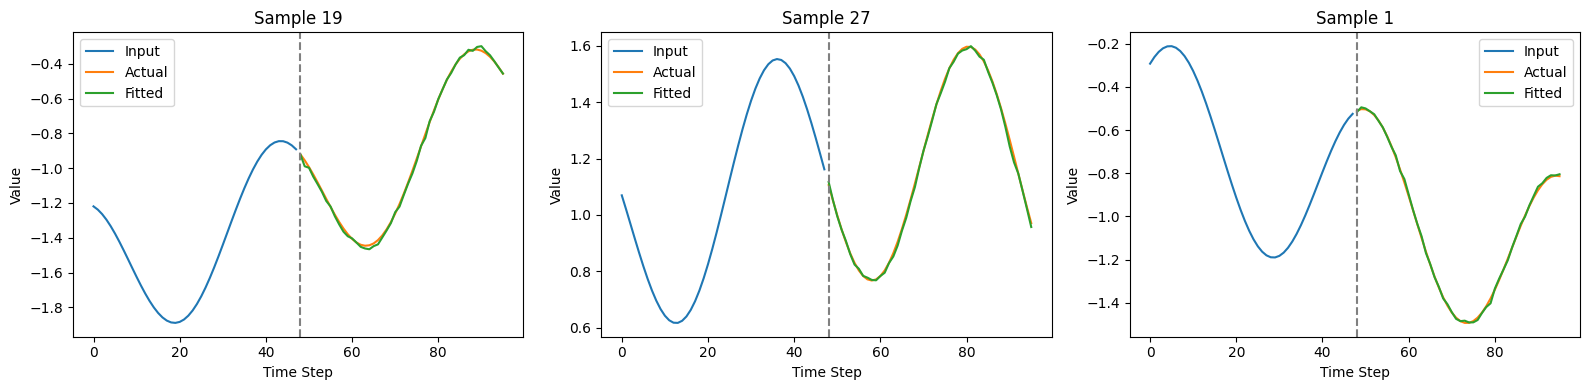

In [ ]:
import random
# Randomly select data samples and visualize results
input_seq, target_seq = next(iter(train_loader))
# input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
output = model(input_seq)


# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Fitted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1}')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()

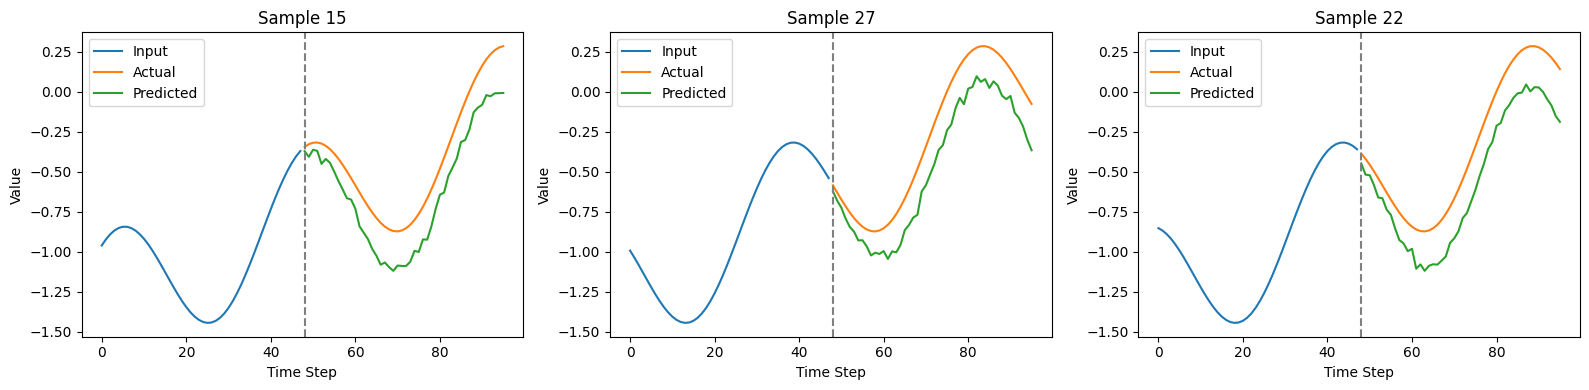

In [ ]:
import random
# Randomly select data samples and visualize results
input_seq, target_seq = next(iter(val_loader))
# input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
output = model(input_seq)


# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Predicted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1}')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()

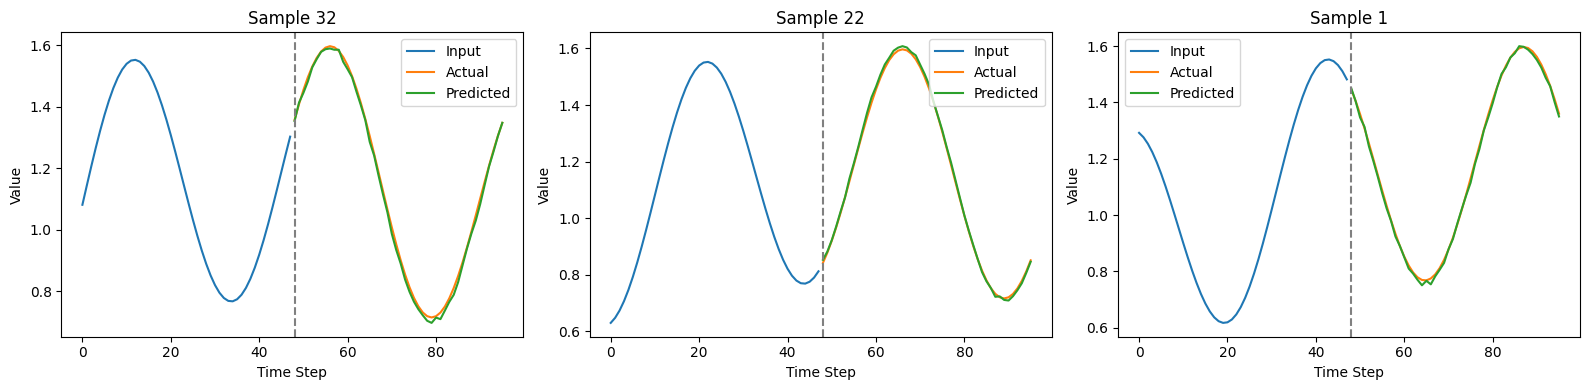

In [ ]:
import random
# Randomly select data samples and visualize results
input_seq, target_seq = next(iter(test_loader))
# input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
output = model(input_seq)


# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Predicted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1}')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()

# Mamba2

In [ ]:
!pip install mamba_ssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 12.4 MB/s eta 0:00:00
  Created wheel for mamba_ssm: filename=mamba_ssm-2.2.2-cp310-cp310-linux_x86_64.whl size=323803485 sha256=cd8ee941b25398d90c135d3a180b5dc33e478c98ae4998b61749809beaff947a
  Stored in directory: /root/.cache/pip/wheels/57/7c/90/9f963468ecc3791e36e388f9e7b4a4e1e3f90fbb340055aa4d
Successfully built mamba_ssm


In [ ]:
!pip install mamba-ssm[causal-conv1d]

In [ ]:
import sys
import os
from mamba_ssm import Mamba2
import torch.nn as nn # Import PyTorch's nn module

class Mamba2Model(nn.Module):
    def __init__(self, input_size, output_size, patch_size, d_in, d_state, d_conv, expand):
        super(Mamba2Model, self).__init__()
        # Define the S4 model architecture here
        self.patch_embed = PatchEmbedding(patch_size, d_in)
        self.Mamba_layer = Mamba2(
            # This module uses roughly 3 * expand * d_model^2 parameters
            d_model=d_in, # Model dimension d_model
            d_state=d_state,  # SSM state expansion factor, typically 64 or 128
            d_conv=d_conv,    # Local convolution width
            expand=expand,    # Block expansion factor
        ).to("cpu")
        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.patch_embed(x) # x shape: (B, L // patch_size, patch_size)
        x = self.Mamba_layer(x) # x shape: (B, L // patch_size, hidden_size)
        x = self.output_layer(x) # x shape: (B, L // patch_size, output_size)
        return x[:, -1, :]  # only the last patch is used for prediction???

# Hyperparameters
input_len = 8 * 6
output_len = 8 * 6  # number of steps to predict
patch_size = 8
d_state = 64
d_conv = 4
expand = 2
d_in = 64

# Model, loss, and optimizer
model = Mamba2Model(input_size=input_len, output_size=output_len, patch_size=patch_size,
                d_in=d_in, d_state=d_state, d_conv=d_conv, expand=expand)

# Generate some random input data
B, L = 32, 48
x = torch.rand(B, L)  # batch size 32, sequence length 48
output = model(x)
assert output.shape == x.shape

AttributeError: 'NoneType' object has no attribute 'causal_conv1d_fwd'

In [ ]:
# Model initialization
model = Mamba2Model(input_size=input_len, output_size=output_len, patch_size=patch_size,
                   d_model=d_model, d_head=d_head)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_seq, target_seq = batch
        # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
        optimizer.zero_grad()
        output,_ = model(input_seq)
        loss = criterion(output, target_seq)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Testing the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_seq, target_seq = batch
            # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
            output = model(input_seq)
            loss = criterion(output, target_seq)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            input_seq, target_seq = batch
            # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
            output = model(input_seq)
            loss = criterion(output, target_seq)
            test_loss += loss.item()
    test_loss /= len(test_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

AttributeError: 'NoneType' object has no attribute 'causal_conv1d_fwd'

In [ ]:
import random
# Randomly select data samples and visualize results
input_seq, target_seq = next(iter(train_loader))
# input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
output = model(input_seq)


# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Fitted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1}')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()

In [ ]:
import random
# Randomly select data samples and visualize results
input_seq, target_seq = next(iter(val_loader))
# input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
output = model(input_seq)


# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Predicted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1}')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()

In [ ]:
import random
# Randomly select data samples and visualize results
input_seq, target_seq = next(iter(test_loader))
# input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
output = model(input_seq)


# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Predicted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1}')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()